In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# !pip install --upgrade k3d

In [26]:
# !pip install msgpack

In [27]:
from collections import defaultdict
from copy import deepcopy
import json
import os
import warnings

import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed

In [28]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.utils.abc_utils.hdf5.io_struct as io_struct
import sharpf.utils.abc_utils.hdf5.io_struct as io
from sharpf.utils.plotting import display_depth_sharpness

In [44]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r, 
                      plot=None, display=True):
    
    if None is plot:
        plot = k3d.plot(height=plot_height, camera_auto_fit=False)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances and not np.all(samples_distances == 1.0):
            max_dist = 0.5

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            v = -np.array([0., 1., 0.])
            max_dist = np.max(np.dot(samples, v))
            min_dist = np.min(np.dot(samples, v))
            colors = k3d.helpers.map_colors(
                np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)

        plot += k3d_points
        k3d_points.shader='3d'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    if display:
        plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))
    
    return plot

In [30]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

DISPLAY_RES = 0.02 * 1.5

In [8]:
PointPatchPredictionsIO = io_struct.HDF5IO(
        {'points': io_struct.Float64('points'),
         'distances': io_struct.Float64('distances')},
        len_label='distances',
        compression='lzf')

WholeDepthMapIO = io.HDF5IO({
        'image': io.Float64('image'),
        'normals': io.Float64('normals'),
        'distances': io.Float64('distances'),
        'directions': io.Float64('directions'),
        'indexes_in_whole': io.Float64('indexes_in_whole'),
        'item_id': io.AsciiString('item_id'),
        'orig_vert_indices': io.VarInt32('orig_vert_indices'),
        'orig_face_indexes': io.VarInt32('orig_face_indexes'),
        'has_sharp': io.Bool('has_sharp'),
        'num_sharp_curves': io.Int8('num_sharp_curves'),
        'num_surfaces': io.Int8('num_surfaces'),
        'camera_pose': io.Float64('camera_pose'),
        'mesh_scale': io.Float64('mesh_scale'),
        'has_smell_coarse_surfaces_by_num_faces': io.Bool('has_smell_coarse_surfaces_by_num_faces'),
        'has_smell_coarse_surfaces_by_angles': io.Bool('has_smell_coarse_surfaces_by_angles'),
        'has_smell_deviating_resolution': io.Bool('has_smell_deviating_resolution'),
        'has_smell_sharpness_discontinuities': io.Bool('has_smell_sharpness_discontinuities'),
        'has_smell_bad_face_sampling': io.Bool('has_smell_bad_face_sampling'),
        'has_smell_mismatching_surface_annotation': io.Bool('has_smell_mismatching_surface_annotation'),
        'has_smell_raycasting_background': io.Bool('has_smell_raycasting_background'),
        'has_smell_depth_discontinuity': io.Bool('has_smell_depth_discontinuity'),
        'has_smell_mesh_self_intersections': io.Bool('has_smell_mesh_self_intersections'),
    },
    len_label='has_sharp',
    compression='lzf')

In [9]:
def display_sharpness2(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 1.0

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            if samples_color == 'z':
                v = -np.array([0., 1., 0.])
                max_dist = np.max(np.dot(samples, v))
                min_dist = np.min(np.dot(samples, v))
                colors = k3d.helpers.map_colors(
                    np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
                ).astype(np.uint32)
                k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
                
            else:
                k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
                
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [10]:
# UnlabeledPointCloudIO = io.HDF5IO({
#         'points': io.Float64('points'),
#         'indexes_in_whole': io.Int32('indexes_in_whole'),
#         'distances': io.Float64('distances'),
#         'item_id': io.AsciiString('item_id'),
#     },
#     len_label='points',
#     compression='lzf')

# ground_truth_dataset = Hdf5File(
#     '/logs/whole_models_inference_final/gt/points/real_world/small_40.hdf5',
#     io=UnlabeledPointCloudIO,
#     preload=PreloadTypes.LAZY,
#     labels='*')

# idx = np.random.choice(len(ground_truth_dataset))

# ground_truth = [patch for patch in ground_truth_dataset]
# points = ground_truth_dataset[idx]['points']
# # distances = ground_truth_dataset[idx]['distances']
# distances = np.load('/logs/whole_models_inference_final/predictions/points/real_world_high/0.0/d6-v/regression/small_40/predictions/test_{}.npy'.format(idx))

# display_sharpness2(
#     None, plot_meshvert=False, meshvert_psize=0.01,
#     samples=points, 
#     samples_distances=distances,
#     samples_color=0x0000ff, samples_psize=0.1,
#     directions=None)



In [21]:
def make_nice_visuals(
    ground_truth_filename,
    pred_filename,
    output_filename=None,
    display=False,
    display_res=DISPLAY_RES,
    invert=False,
    min_thr=1.0,
):
# item_id = '00500166_5894bbd701b2bb0fc88a6978_007'

# ground_truth_filename = os.path.join(
#     '/logs/whole_models_inference_final/combined/images/high_res/0.0/resnet152/regression/abc_0050_{}__ground_truth.hdf5'.format(item_id))
    ground_truth_dataset = Hdf5File(
        ground_truth_filename,
        io=PointPatchPredictionsIO,
        preload=PreloadTypes.LAZY,
        labels='*')

#     ground_truth = [patch for patch in ground_truth_dataset]
    points = ground_truth_dataset[0]['points']
    distances = ground_truth_dataset[0]['distances']
    print(len(points))
    if invert:
        distances = 1. - distances

    plot = display_sharpness(
        None, plot_meshvert=False, meshvert_psize=0.01,
        samples=points, 
        samples_distances=distances,
        samples_color=0x0000ff, samples_psize=display_res,
        directions=None,
        plot=None, display=False)


#     pred_filename = os.path.join(
#         '/logs/whole_models_inference_final/combined/images/high_res/0.0/resnet152/regression/abc_0050_{}__min.hdf5'.format(item_id))
    pred_dataset = Hdf5File(
        pred_filename,
        io=PointPatchPredictionsIO,
        preload=PreloadTypes.LAZY,
        labels='*')
    pred_points = pred_dataset[0]['points']
    pred_distances = pred_dataset[0]['distances']
    if invert:
        pred_distances = 1. - pred_distances
    
    pred_distances[pred_distances > min_thr] = min_thr
    pred_distances /= min_thr

    plot = display_sharpness(
        None, plot_meshvert=False, meshvert_psize=0.01,
        samples=pred_points, 
        samples_distances=pred_distances,
        samples_color=0x0000ff, samples_psize=display_res,
        directions=None,
        plot=plot, display=display)
    
    if None is not output_filename:
        with open(output_filename, 'w') as f:
            f.write(plot.get_snapshot())
    
    return plot

In [ ]:
item_id = 'nozel_decimated_17_nonoise.obj__13.2mm'
d = '/logs/whole_models_inference_final/combined/images/real_world_high/0.08/resnet152/regression'
ground_truth_filename = os.path.join(d, '{}__ground_truth.hdf5'.format(item_id))
pred_filename = os.path.join(d, '{}__min.hdf5'.format(item_id))

make_nice_visuals(
    ground_truth_filename,
    pred_filename,
    display=True,
    min_thr=0.2,
    output_filename='x.html')

2696516


In [ ]:
with open('/logs/whole_models_inference_final/printed_models.txt') as f:
    instance_names = f.read().splitlines()

In [ ]:
modality = 'images'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'min'
noise_by_res = {
    'high_res': ['0.0', '0.005', '0.02', '0.08'],
    'med_res': ['0.0'],
    'low_res': ['0.0'],
}
RES_BY_NAME = {
    'high_res': HIGH_RES,
    'med_res': MED_RES,
    'low_res': LOW_RES,
}

for instance_name in instance_names:
    for res in ['high_res', 'med_res', 'low_res']:
        for noise in noise_by_res[res]:
#             for model in ['d6', 'd6-v']:
            for model in ['resnet152']:
                for task in ['regression', 'segmentation']:
                    print(modality, res, noise, model, task, instance_name)

                    ground_truth_filename = os.path.join(
                        base_dir, 
                        res,
                        noise,
                        model,
                        task,
                        'abc_0050_{}__ground_truth.hdf5'.format(instance_name))
                    pred_filename = os.path.join(
                        base_dir, 
                        res,
                        noise,
                        model,
                        task,
                        'abc_0050_{}__{}.hdf5'.format(instance_name, pred_variant))

                    if not os.path.exists(ground_truth_filename):
    #                     print('GT {} does not exist, skipping'.format(ground_truth_filename))
                        continue 

                    if not os.path.exists(pred_filename):
    #                     print('PRED {} does not exist, skipping'.format(pred_filename))
                        continue

                    output_filename = os.path.join(
                        visuals_dir,
                        '{modality}_{res}_{noise}_{model}_{task}_{file}'.format(
                            modality=modality,
                            res=res,
                            noise=noise,
                            model=model,
                            task=task,
                            file='abc_0050_{}__ground_truth__{}.html'.format(instance_name, pred_variant)
                        ))
                    if os.path.exists(output_filename):
    #                     print('OUTPUT {} exists, skipping'.format(output_filename))
                        continue

                    print(ground_truth_filename)
                    print(pred_filename)
                    print(output_filename)
                    print()

#                     make_nice_visuals(
#                         ground_truth_filename,
#                         pred_filename,
#                         display=False,
#                         output_filename=output_filename,
#                         display_res=RES_BY_NAME[res] * 1.5,
#                     )


In [ ]:
with open('/logs/whole_models_inference_final/ct_scans.txt') as f:
    instance_names = f.read().splitlines()
    
modality = 'images'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'min'
noise_by_res = {
    'high_res': ['0.0', '0.005', '0.02', '0.08'],
    'med_res': ['0.0'],
    'low_res': ['0.0'],
}
RES_BY_NAME = {
    'high_res': HIGH_RES,
    'med_res': MED_RES,
    'low_res': LOW_RES,
}

for instance_name in instance_names:
    for res in ['high', 'med', 'low']:
        for noise in noise_by_res[res + '_res']:
#             for model in ['d6', 'd6-v']:
            for model in ['resnet152']:
                for task in ['regression', 'segmentation']:
                    print(modality, res, noise, model, task, instance_name)

                    ground_truth_filename = os.path.join(
                        base_dir, 
                        'real_world_' + res,
                        noise,
                        model,
                        task,
                        '{}__ground_truth.hdf5'.format(instance_name))
                    pred_filename = os.path.join(
                        base_dir, 
                        'real_world_' + res,
                        noise,
                        model,
                        task,
                        '{}__{}.hdf5'.format(instance_name, pred_variant))

                    if not os.path.exists(ground_truth_filename):
                        print('GT {} does not exist, skipping'.format(ground_truth_filename))
                        continue 

                    if not os.path.exists(pred_filename):
    #                     print('PRED {} does not exist, skipping'.format(pred_filename))
                        continue

                    output_filename = os.path.join(
                        visuals_dir,
                        '{modality}_{res}_{noise}_{model}_{task}_{file}'.format(
                            modality=modality,
                            res='real_world_' + res,
                            noise=noise,
                            model=model,
                            task=task,
                            file='{}__ground_truth__{}.html'.format(instance_name, pred_variant)
                        ))
                    if os.path.exists(output_filename):
    #                     print('OUTPUT {} exists, skipping'.format(output_filename))
                        continue

                    print(ground_truth_filename)
                    print(pred_filename)
                    print(output_filename)
                    print()

                    make_nice_visuals(
                        ground_truth_filename,
                        pred_filename,
                        display=False,
                        output_filename=output_filename,
                        display_res=RES_BY_NAME[res + '_res'] * 1.5,
                    )



In [ ]:
!ls /logs/whole_models_inference_final/combined/images/high_res/0.0/

In [ ]:
with open('/logs/whole_models_inference_final/sl_scans_points.txt') as f:
    instance_names = f.read().splitlines()

modality = 'points'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'crop__adv60__min'
noise_by_res = {
    'high_res': ['0.0', '0.005', '0.02', '0.08'],
    'med_res': ['0.0'],
    'low_res': ['0.0'],
}
RES_BY_NAME = {
    'high_res': HIGH_RES,
    'med_res': MED_RES,
    'low_res': LOW_RES,
}

for instance_name in instance_names:
    for res in ['high', 'med', 'low']:
        for noise in noise_by_res[res + '_res']:
            for model in ['d6-v']:
#             for model in ['resnet152']:
                for task in ['regression']:
                    print(modality, res, noise, model, task, instance_name)

                    ground_truth_filename = os.path.join(
                        base_dir, 
                        'real_world_' + res,
                        noise,
                        model,
                        task,
                        '{}__ground_truth.hdf5'.format(instance_name))
                    pred_filename = os.path.join(
                        base_dir, 
                        'real_world_' + res,
                        noise,
                        model,
                        task,
                        '{}__{}.hdf5'.format(instance_name, pred_variant))

                    if not os.path.exists(ground_truth_filename):
                        print('GT {} does not exist, skipping'.format(ground_truth_filename))
                        continue 

                    if not os.path.exists(pred_filename):
    #                     print('PRED {} does not exist, skipping'.format(pred_filename))
                        continue

                    output_filename = os.path.join(
                        visuals_dir,
                        '{modality}_{res}_{noise}_{model}_{task}_{file}'.format(
                            modality=modality,
                            res='real_world_' + res,
                            noise=noise,
                            model=model,
                            task=task,
                            file='{}__ground_truth__{}.html'.format(instance_name, pred_variant)
                        ))
                    if os.path.exists(output_filename):
    #                     print('OUTPUT {} exists, skipping'.format(output_filename))
                        continue

                    print(ground_truth_filename)
                    print(pred_filename)
                    print(output_filename)
                    print()

#                     make_nice_visuals(
#                         ground_truth_filename,
#                         pred_filename,
#                         display=False,
#                         output_filename=output_filename,
#                         display_res=RES_BY_NAME[res + '_res'] * 1.5,
#                     )


In [ ]:
with open('/logs/whole_models_inference_final/printed_models.txt') as f:
    instance_names = f.read().splitlines()

modality = 'points'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'vote_0.50'
noise_by_res = {
    'high_res': ['0.0', '0.005', '0.02', '0.08'],
    'med_res': ['0.0'],
    'low_res': ['0.0'],
}
RES_BY_NAME = {
    'high_res': HIGH_RES,
    'med_res': MED_RES,
    'low_res': LOW_RES,
}

for instance_name in instance_names:
    for res in ['high', 'med', 'low']:
        for noise in noise_by_res[res + '_res']:
            for model in ['voronoi', 'sharpness', 'ecnet']:
                    print(modality, res, noise, model, instance_name)

                    ground_truth_filename = os.path.join(
                        base_dir, 
                        res + '_res',
                        noise,
                        model,
                        'abc_0050_{}__ground_truth.hdf5'.format(instance_name))
                    pred_filename = os.path.join(
                        base_dir, 
                        res + '_res',
                        noise,
                        model,
                        'abc_0050_{}__{}.hdf5'.format(instance_name, pred_variant))

                    if not os.path.exists(ground_truth_filename):
                        print('GT {} does not exist, skipping'.format(ground_truth_filename))
                        continue 

                    if not os.path.exists(pred_filename):
                        print('PRED {} does not exist, skipping'.format(pred_filename))
                        continue

                    output_filename = os.path.join(
                        visuals_dir,
                        '{modality}_{res}_{noise}_{model}_{file}'.format(
                            modality=modality,
                            res=res + '_res',
                            noise=noise,
                            model=model,
                            file='{}__ground_truth__{}.html'.format(instance_name, pred_variant)
                        ))
                    if os.path.exists(output_filename):
    #                     print('OUTPUT {} exists, skipping'.format(output_filename))
                        continue

                    print(ground_truth_filename)
                    print(pred_filename)
                    print(output_filename)
                    print()

                    make_nice_visuals(
                        ground_truth_filename,
                        pred_filename,
                        display=False,
                        output_filename=output_filename,
                        display_res=RES_BY_NAME[res + '_res'] * 1.5,
                        invert=True
                    )



In [ ]:
ls /logs/whole_models_inference_final/combined/points/high/0.0/voronoi/

In [ ]:
with open('/logs/whole_models_inference_final/sl_scans_points.txt') as f:
    instance_names = f.read().splitlines()

modality = 'points'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'vote_0.50'

for instance_name in instance_names:
    for model in ['voronoi']:
        print(modality, model, instance_name)

        ground_truth_filename = os.path.join(
            base_dir, 
            'real_world',
            model,
            '{}__ground_truth.hdf5'.format(instance_name))
        pred_filename = os.path.join(
            base_dir,
            'real_world',
            model,
            '{}__{}.hdf5'.format(instance_name, pred_variant))

        if not os.path.exists(ground_truth_filename):
            print('GT {} does not exist, skipping'.format(ground_truth_filename))
            continue 

        if not os.path.exists(pred_filename):
#                     print('PRED {} does not exist, skipping'.format(pred_filename))
            continue

        output_filename = os.path.join(
            visuals_dir,
            '{modality}_{model}_{file}'.format(
                modality=modality,
                res='real_world',
                model=model,
                file='{}__ground_truth__{}.html'.format(instance_name, pred_variant)
            ))
        if os.path.exists(output_filename):
#                     print('OUTPUT {} exists, skipping'.format(output_filename))
            continue

        print(ground_truth_filename)
        print(pred_filename)
        print(output_filename)
        print()

        make_nice_visuals(
            ground_truth_filename,
            pred_filename,
            display=False,
            output_filename=output_filename,
            display_res=RES_BY_NAME[res + '_res'] * 1.5,
            invert=True
        )



In [ ]:
ground_truth_dataset = Hdf5File(
    '/logs/whole_models_inference_final/combined/points/real_world/voronoi/bat_320__ground_truth.hdf5',
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

points = ground_truth_dataset[0]['points']
distances = ground_truth_dataset[0]['distances']
print(len(points))

display_sharpness2(
    None, plot_meshvert=False, meshvert_psize=0.01,
    samples=points, 
    samples_distances=distances,
    samples_color=0x0000ff, samples_psize=0.01,
    directions=None)

In [31]:
UnlabeledSLDepthMapIO = io.HDF5IO({
        'image': io.Float64('image'),
        'image_offset': io.Float64('image_offset'),
        'item_id': io.AsciiString('item_id'),
        'camera_extrinsics': io.Float64('camera_extrinsics'),
        'camera_intrinsics_f': io.Float64('camera_intrinsics_f'),
        'camera_intrinsics_s': io.Float64('camera_intrinsics_s'),
    },
    len_label='has_sharp',
    compression='lzf')

In [86]:
gt_images_dataset = Hdf5File(
    '/data/abc/sharp_features_whole_models/whole_images/low_complexity/abc_0022_00221312_0cdd179f2b755db6d27ea303_001.hdf5',
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_images_dataset = Hdf5File(
    '/logs/whole_images/nobg_nodisc/abc_0022_00221312_0cdd179f2b755db6d27ea303_001__predictions.hdf5',
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels=['distances'])

gt_images = [p['image'][128:-128, 128:-128] for p in gt_images_dataset]
gt_distances = [p['distances'][128:-128, 128:-128] for p in gt_images_dataset]
pred_images_distances = [p['distances'][128:-128, 128:-128] for p in pred_images_dataset]

File /logs/whole_images/nobg_nodisc/abc_0022_00221312_0cdd179f2b755db6d27ea303_001__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>
File /logs/whole_images/nobg_nodisc/abc_0022_00221312_0cdd179f2b755db6d27ea303_001__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>


In [87]:
pred_images_distances_masked = []
for image, distances in zip(gt_images, pred_images_distances):
    distances_masked = np.zeros_like(distances)
    distances_masked[image == 0.] = 0.
    distances_masked[image != 0.] = distances[image != 0.]
    pred_images_distances_masked.append(distances_masked)

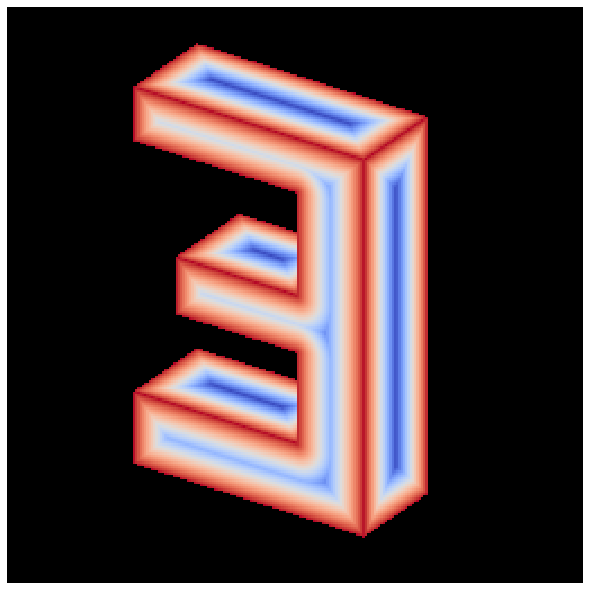

In [91]:


display_depth_sharpness(
#     depth_images=[gt_images[4].T],
    sharpness_images=[gt_distances[4].T],
    axes_size=(8, 8),
    ncols=1
)

In [ ]:
plt.hist(gt_images[0].ravel()[gt_images[0].ravel()!=0] - min(gt_images[0].ravel()[gt_images[0].ravel()!=0]), bins=100)

In [95]:
import trimesh.transformations as tt

array([[ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [-0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [168]:
# pred_filename = os.path.join('/logs/whole_models_inference/abc_0022_00220226_b79b40ef8721383269a6542c_000__crop__linreg.hdf5')
# pred_filename = os.path.join(
#     '/logs/whole_images/arbitrary/abc_0022_00221312_0cdd179f2b755db6d27ea303_001__min.hdf5')
input_dir = '/logs/whole_models_inference_final/combined/points/low_res/0.0/d6/regression'
pred_dataset = Hdf5File(
    os.path.join(input_dir, 'abc_0050_00507625_b39680dc8dc650ec01956bbe_011__crop__linreg.hdf5'),
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_points = pred_dataset[0]['points'] - np.mean(pred_dataset[0]['points'], axis=0)
pred_distances = pred_dataset[0]['distances']

display_sharpness(None, plot_meshvert=False, meshvert_psize=0.01,
                  samples=tt.transform_points(pred_points, tt.euler_matrix(-np.pi/4, 0, 0, axes='sxyz'))*0.15, 
                  samples_distances=pred_distances,
                  samples_color=0x0000ff, samples_psize=LOW_RES * 2.5 *0.15,
                  directions=None)

Output()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0, 0…